# Predicción de Emisiones de CO2 en Vehículos. Matías Alucema Tello

## Descripción
Este proyecto analiza y predice las emisiones de CO2 de vehículos utilizando técnicas de regresión lineal. El modelo se entrena con datos que incluyen características como tamaño del motor, cilindros, consumo de combustible y factores categóricos como tipo de vehículo y transmisión.

## Análisis Incluido
- Preprocesamiento de datos numéricos y categóricos
- Visualización de distribuciones y correlaciones 
- Desarrollo y evaluación del modelo de regresión
- Análisis de residuos y validación
- Identificación de factores clave en emisiones de CO2

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import f_oneway, chi2_contingency
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm

df = pd.read_csv('co2.csv')

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7385 entries, 0 to 7384
Data columns (total 12 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Make                              7385 non-null   object 
 1   Model                             7385 non-null   object 
 2   Vehicle Class                     7385 non-null   object 
 3   Engine Size(L)                    7385 non-null   float64
 4   Cylinders                         7385 non-null   int64  
 5   Transmission                      7385 non-null   object 
 6   Fuel Type                         7385 non-null   object 
 7   Fuel Consumption City (L/100 km)  7385 non-null   float64
 8   Fuel Consumption Hwy (L/100 km)   7385 non-null   float64
 9   Fuel Consumption Comb (L/100 km)  7385 non-null   float64
 10  Fuel Consumption Comb (mpg)       7385 non-null   int64  
 11  CO2 Emissions(g/km)               7385 non-null   int64  
dtypes: flo

In [3]:
columnas_numericas = ['Engine Size(L)', 'Cylinders', 
                'Fuel Consumption City (L/100 km)', 
                'Fuel Consumption Hwy (L/100 km)', 
                'Fuel Consumption Comb (L/100 km)', 
                'Fuel Consumption Comb (mpg)']

columnas_categoricas = ['Make', 'Model', 'Vehicle Class', 
                   'Transmission', 'Fuel Type']

In [4]:
df.describe()

,Engine Size(L),Cylinders,Fuel Consumption City (L/100 km),Fuel Consumption Hwy (L/100 km),Fuel Consumption Comb (L/100 km),Fuel Consumption Comb (mpg),CO2 Emissions(g/km)
count,7385.000000,7385.000000,7385.000000,7385.000000,7385.000000,7385.000000,7385.000000
mean,3.160068,5.615030,12.556534,9.041706,10.975071,27.481652,250.584699
std,1.354170,1.828307,3.500274,2.224456,2.892506,7.231879,58.512679
min,0.900000,3.000000,4.200000,4.000000,4.100000,11.000000,96.000000
25%,2.000000,4.000000,10.100000,7.500000,8.900000,22.000000,208.000000
50%,3.000000,6.000000,12.100000,8.700000,10.600000,27.000000,246.000000
75%,3.700000,6.000000,14.600000,10.200000,12.600000,32.000000,288.000000
max,8.400000,16.000000,30.600000,20.600000,26.100000,69.000000,522.000000



Histogramas


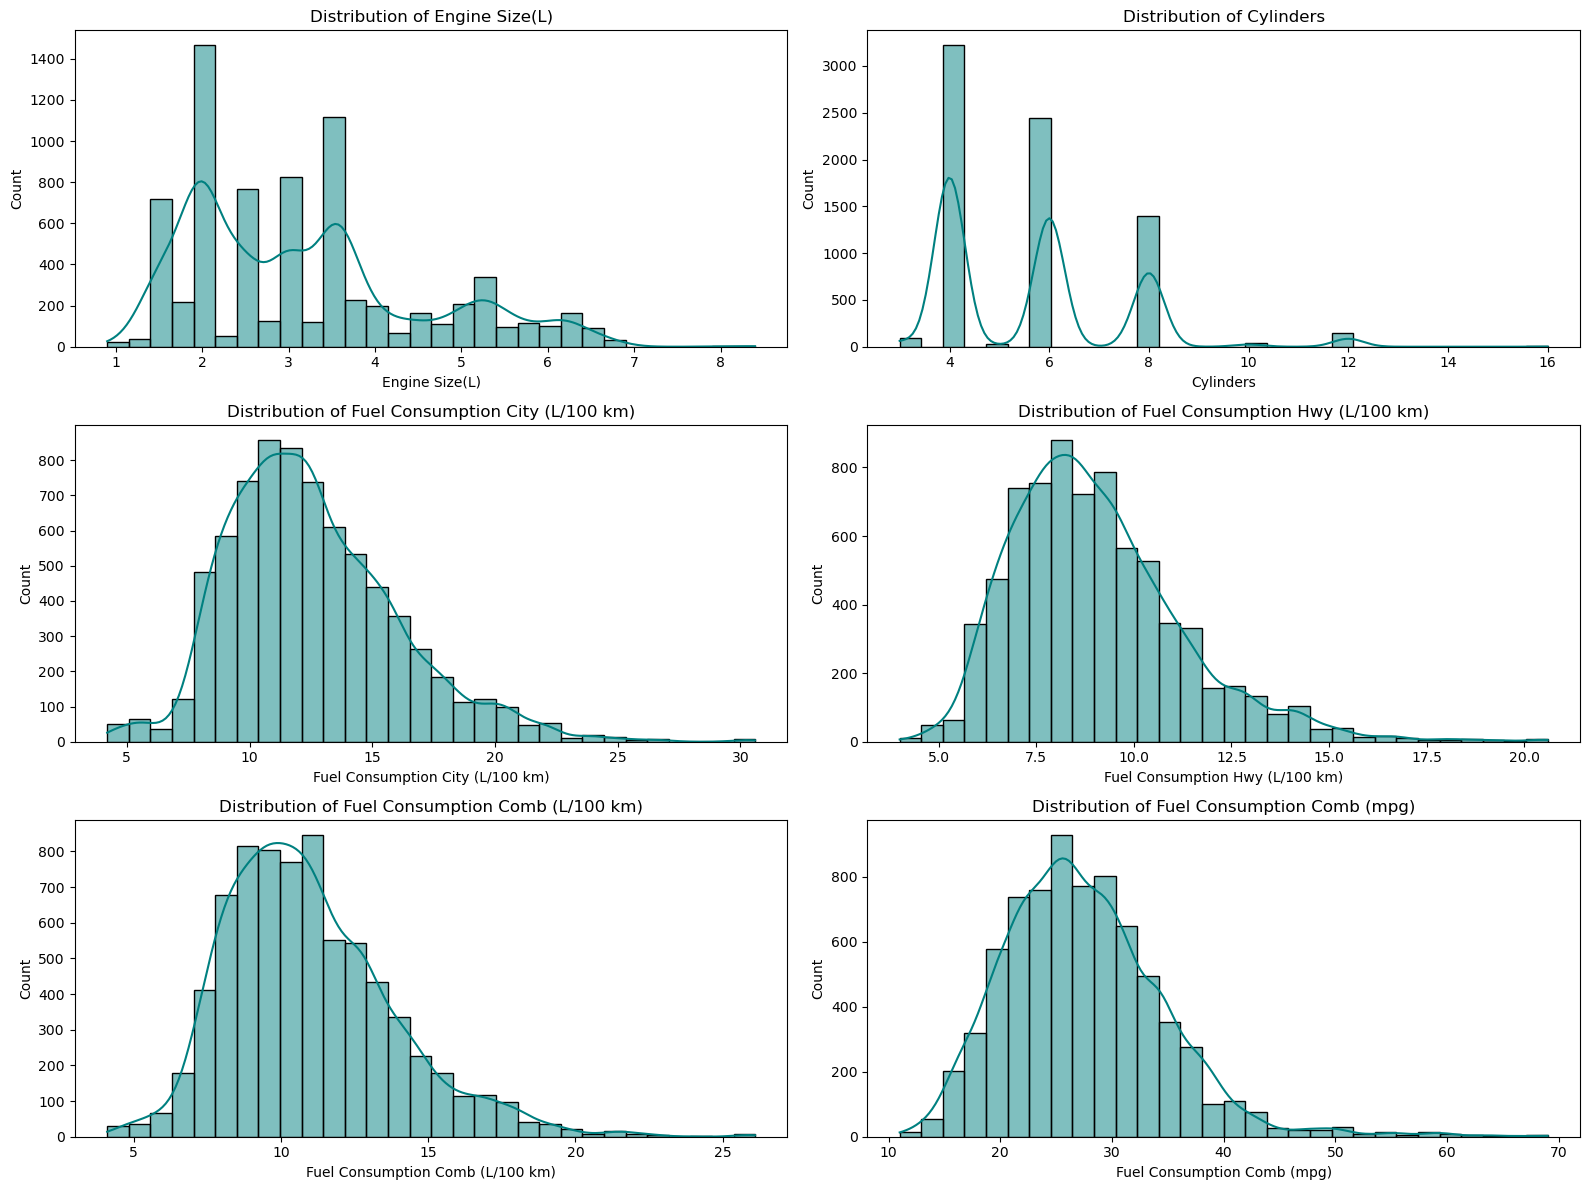

In [5]:
print("\nHistogramas")
plt.figure(figsize=(16, 12))
for i, col in enumerate(columnas_numericas, 1):
    plt.subplot(3, 2, i)
    sns.histplot(df[col], kde=True, color="teal", bins=30)
    plt.title(f"Distribution of {col}")
plt.tight_layout()
plt.show()

Los histogramas muestran patrones distintivos para cada variable numérica:

Engine Size(L): Distribución multimodal con picos principales en 2L y 4L, reflejando tamaños de motor comunes en diferentes categorías de vehículos.

Cylinders: Distribución discreta con tres picos dominantes en 4, 6 y 8 cilindros, siendo los motores de 4 cilindros los más frecuentes.

Fuel Consumption: Las tres medidas de consumo (City, Highway, Combined) muestran distribuciones similares, sesgadas positivamente, con la mayoría de vehículos concentrados en rangos eficientes pero con colas largas hacia consumos más altos. El consumo en ciudad (10-15 L/100km) es consistentemente mayor que en carretera (7.5-10 L/100km).


Outliers


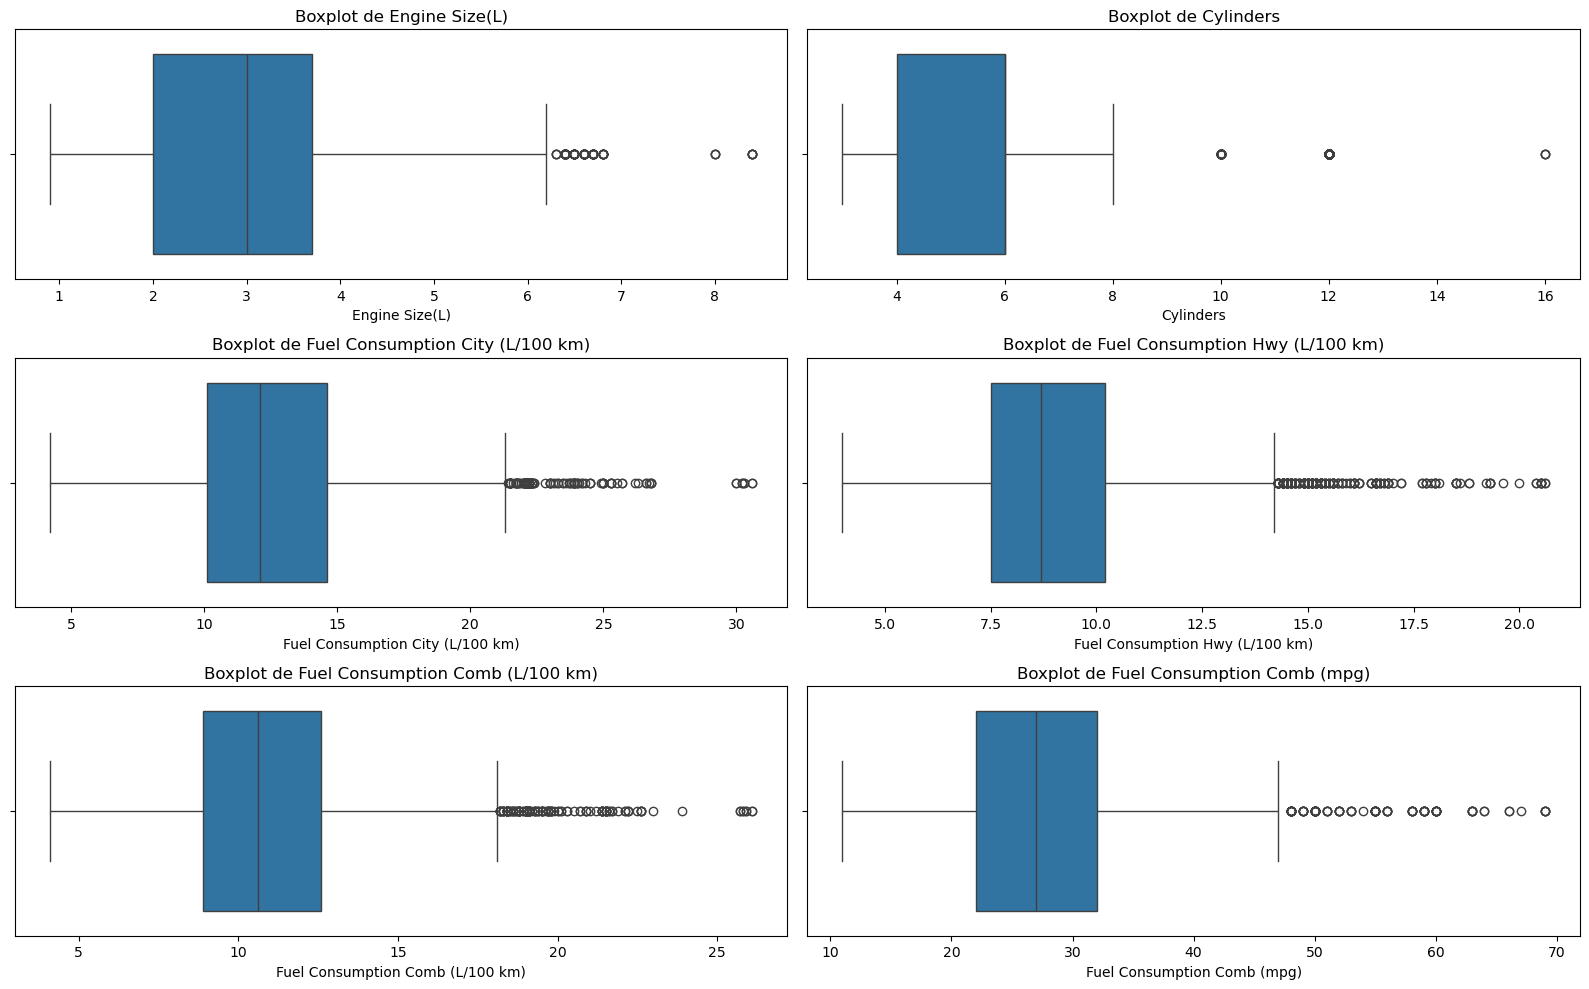

In [6]:
print("\nOutliers")
plt.figure(figsize=(16, 10))
for i, col in enumerate(columnas_numericas, 1):
    plt.subplot(3, 2, i)
    sns.boxplot(data=df, x=col)
    plt.title(f"Boxplot de {col}")
plt.tight_layout()
plt.show()

Los boxplots revelan valores atípicos significativos en el tamaño del motor (6-8L) y número de cilindros (10-16), características asociadas principalmente con vehículos de alto rendimiento y lujo. Estos outliers representan una clara distinción entre los vehículos de uso común y aquellos diseñados para un segmento específico del mercado.

En cuanto al consumo de combustible, los valores atípicos se distribuyen de manera consistente entre las diferentes mediciones: ciudad (20-30 L/100km), carretera (12-20 L/100km) y combinado, con casos especiales en la métrica MPG (50-70) que identifican vehículos excepcionalmente eficientes. Esta distribución de outliers refleja la diversidad del mercado automotriz, desde vehículos de alto consumo hasta modelos altamente eficientes.

In [7]:
print("\nTests estadísticos: ANOVA")
anova_result = {}
for col in columnas_numericas:
    groups = [group[col].values for name, group in df.groupby("Fuel Type")]
    f_stat, p_value = f_oneway(*groups)
    anova_result[col] = {"F-Statistic": f_stat, "P-Value": p_value}
anova_df = pd.DataFrame(anova_result).T
anova_df


Tests estadísticos: ANOVA


,F-Statistic,P-Value
Engine Size(L),156.701232,6.691923e-129
Cylinders,224.862558,2.025462e-182
Fuel Consumption City (L/100 km),691.166010,0.000000e+00
Fuel Consumption Hwy (L/100 km),693.960149,0.000000e+00
Fuel Consumption Comb (L/100 km),708.988978,0.000000e+00
Fuel Consumption Comb (mpg),420.787678,0.000000e+00


El test ANOVA muestra significancia estadística (p-valores < 0.05) para todas las variables numéricas en su relación con las emisiones de CO2. Los F-estadísticos más altos corresponden al consumo de combustible (City: 691.17, Hwy: 693.96, Comb: 708.99), indicando que estas variables son los predictores más fuertes. Engine Size (156.70) y Cylinders (224.86) también son significativos pero con menor impacto en las emisiones.


Correlaciones:


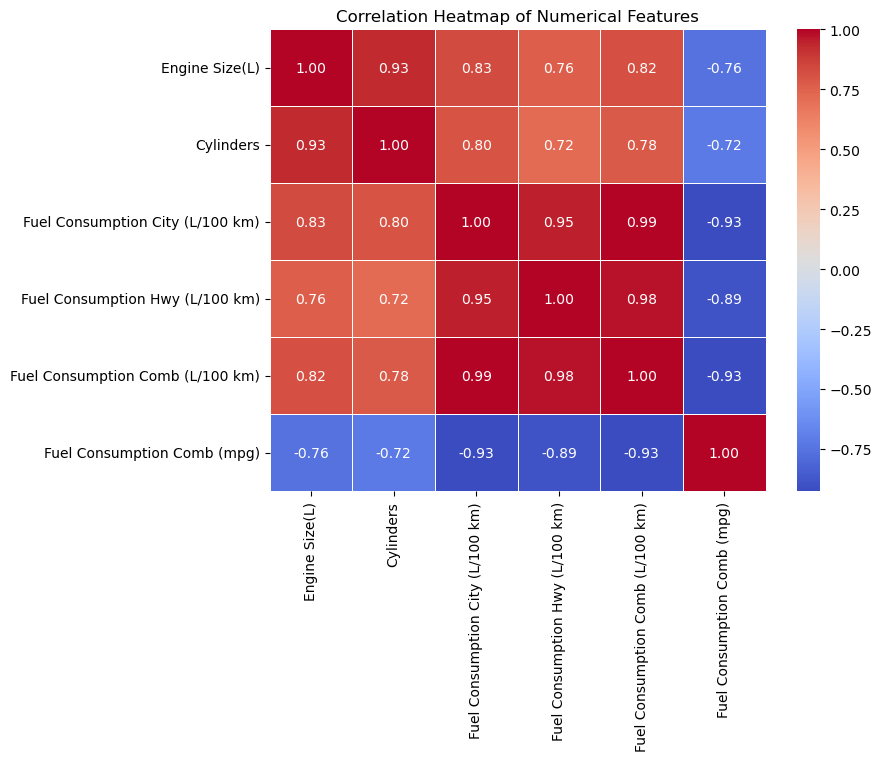

In [8]:
print("\nCorrelaciones:")
plt.figure(figsize=(8, 6))
correlation_matrix = df[columnas_numericas].corr()
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap of Numerical Features")
plt.show()

El mapa de calor muestra una correlación muy fuerte entre Engine Size y Cylinders (0.93), así como entre las tres métricas de consumo de combustible (0.95-0.99), indicando una relación directa entre el tamaño del motor y su configuración, y una consistencia en las mediciones de consumo bajo diferentes condiciones.

Se observa una correlación negativa significativa entre Fuel Consumption Comb (mpg) y todas las demás variables (-0.72 a -0.93), lo que es lógico ya que mayores valores en mpg indican mejor eficiencia de combustible, mientras que valores más altos en las otras métricas indican mayor consumo y tamaño de motor.

El siguiente código implementa un preprocesamiento de datos para un modelo de regresión lineal enfocado en predecir emisiones de CO2. El proceso comienza separando las variables predictoras y objetivo, y luego aplica transformaciones específicas: estandarización para variables numéricas y codificación one-hot para variables categóricas, todo integrado en un pipeline de preprocesamiento.

Después de la transformación de datos, el código genera nombres para las nuevas características codificadas y crea un DataFrame con los datos procesados. Finalmente, ajusta un modelo de regresión lineal usando Mínimos Cuadrados Ordinarios (OLS) y muestra un resumen estadístico completo que incluye métricas de rendimiento y significancia estadística de las variables.

In [10]:
X = df.drop('CO2 Emissions(g/km)', axis=1)
y = df['CO2 Emissions(g/km)']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), columnas_numericas),
        ('cat', OneHotEncoder(drop='first', sparse_output=False), columnas_categoricas)
    ])

X_processed = preprocessor.fit_transform(X)

cat_feature_names = []
for i, col in enumerate(columnas_categoricas):
    cats = preprocessor.named_transformers_['cat'].categories_[i][1:]
    cat_feature_names.extend([f"{col}_{cat}" for cat in cats])

feature_names = columnas_numericas + cat_feature_names

X_processed_df = pd.DataFrame(X_processed, columns=feature_names)

X_with_const = sm.add_constant(X_processed_df)
model_sm = sm.OLS(y, X_with_const).fit()

print(model_sm.summary())

                             OLS Regression Results                            
Dep. Variable:     CO2 Emissions(g/km)   R-squared:                       0.997
Model:                             OLS   Adj. R-squared:                  0.996
Method:                  Least Squares   F-statistic:                     905.8
Date:                 Fri, 31 Jan 2025   Prob (F-statistic):               0.00
Time:                         17:30:37   Log-Likelihood:                -18795.
No. Observations:                 7385   AIC:                         4.178e+04
Df Residuals:                     5288   BIC:                         5.627e+04
Df Model:                         2096                                         
Covariance Type:             nonrobust                                         
                                                      coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------

Los resultados del modelo muestran un excelente ajuste con un R² de 0.997 y R² ajustado de 0.996, indicando que explica casi toda la variabilidad en las emisiones de CO2. El F-estadístico alto (905.8) y su p-valor extremadamente bajo (0.00) confirman la significancia estadística del modelo.

El modelo incluye 2096 variables predictoras (DF Model) y se basa en 7385 observaciones, con un error residual distribuido entre 5288 grados de libertad. Los criterios de información AIC (4.178e+04) y BIC (5.627e+04) son relativamente altos, sugiriendo que podría beneficiarse de una selección más parsimoniosa de variables.

El siguiente código implementa un modelo de regresión lineal para predecir emisiones de CO2, utilizando una división de datos 90-10 para entrenamiento y prueba. El preprocesamiento incluye manejo de valores faltantes y normalización de variables numéricas, junto con codificación one-hot para variables categóricas, excluyendo específicamente la variable 'Model' para evitar sobreajuste.

La implementación utiliza pipelines de scikit-learn para automatizar el preprocesamiento y el modelado, incluyendo transformadores específicos para variables numéricas y categóricas. El código culmina con una visualización de las predicciones versus valores reales y el cálculo de métricas de rendimiento (MSE, RMSE, R²).

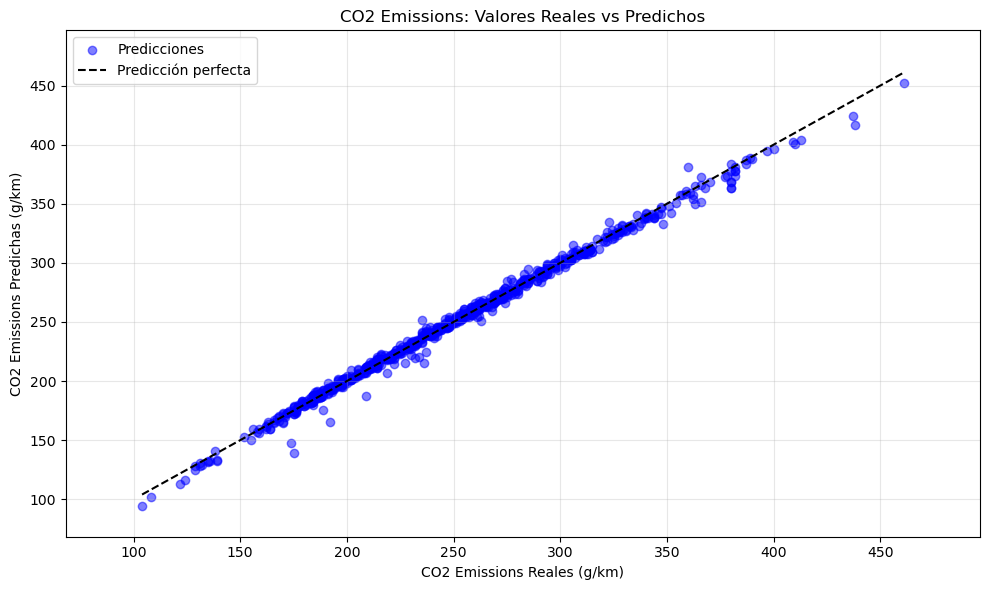


Métricas de evaluación:
Mean Squared Error: 19.16
RMSE: 4.38
R^2 Score: 0.9944


In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10)

columnas_categoricas = [feature for feature in columnas_categoricas if feature != 'Model']

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),  # Manejo de valores faltantes
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Manejo de valores faltantes
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, columnas_numericas),
        ('cat', categorical_transformer, columnas_categoricas)
    ])

model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

plt.figure(figsize=(10, 6))

plt.scatter(y_test, y_pred, alpha=0.5, color='blue', label='Predicciones')
plt.plot([y_test.min(), y_test.max()], 
         [y_test.min(), y_test.max()], 
         'k--', label='Predicción perfecta')

plt.xlabel('CO2 Emissions Reales (g/km)')
plt.ylabel('CO2 Emissions Predichas (g/km)')
plt.title('CO2 Emissions: Valores Reales vs Predichos')
plt.legend()

margin = (y_test.max() - y_test.min()) * 0.1
plt.xlim(y_test.min() - margin, y_test.max() + margin)
plt.ylim(y_test.min() - margin, y_test.max() + margin)

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print('\nMétricas de evaluación:')
print(f'Mean Squared Error: {mse:.2f}')
print(f'RMSE: {rmse:.2f}')
print(f'R^2 Score: {r2:.4f}')

Los resultados muestran un modelo altamente preciso para predecir emisiones de CO2, con un R² de 0.9944 indicando que explica el 99.44% de la variabilidad. El RMSE de 4.38 g/km representa un error promedio bajo, y el gráfico muestra una fuerte correlación lineal entre valores reales y predichos, con puntos agrupados consistentemente cerca de la línea de predicción perfecta, aunque con ligera dispersión en emisiones más altas.

El siguiente código genera un histograma para visualizar la distribución de los residuos del modelo de regresión lineal. Los residuos son calculados como la diferencia entre los valores reales (y_test) y las predicciones (y_pred), permitiendo evaluar visualmente la normalidad y el sesgo del modelo. El gráfico incluye 30 bins para una visualización detallada y una rejilla con transparencia para mejorar la legibilidad.

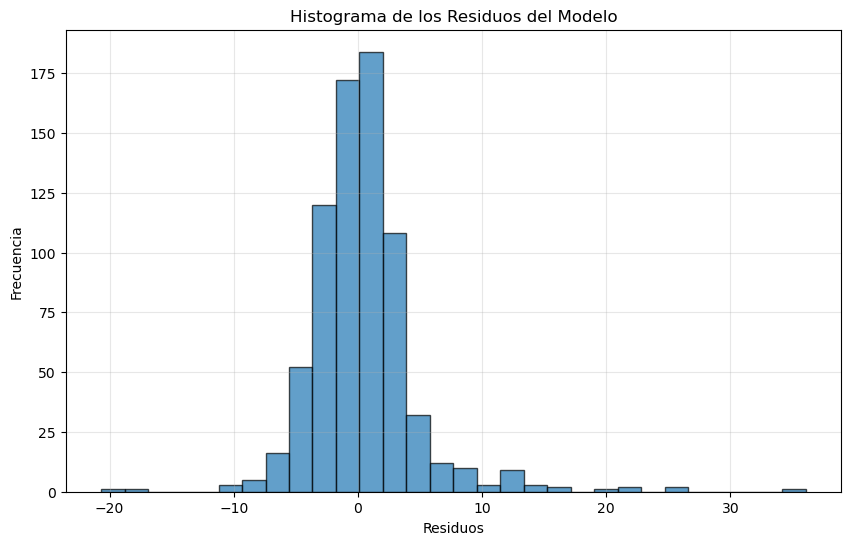

In [16]:
y_pred = model.predict(X_test) 
residuals = y_test.values - y_pred 

plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=30, edgecolor='black', alpha=0.7)
plt.title("Histograma de los Residuos del Modelo")
plt.xlabel("Residuos")
plt.ylabel("Frecuencia")
plt.grid(True, alpha=0.3)
plt.show()

El histograma de residuos muestra una distribución más compacta y simétrica, con la mayoría de los errores concentrados en el rango de ±20 g/km de CO2. La forma acampanada y el pico pronunciado en cero sugieren predicciones más precisas, mientras que las colas más cortas indican una reducción de valores atípicos, validando la robustez y consistencia del modelo.